In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import pickle
import os
import scipy
import seaborn as sns
from datetime import datetime
#%env CUDA_VISIBLE_DEVICES=3
import torch
from utils import sample_pt_cells_scvi, viz_props

Global seed set to 0


In [2]:
import random

def set_random_seed(seed_value=42):
    """Set random seed for reproducibility."""
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using CUDA
    np.random.seed(seed_value)
    random.seed(seed_value)

# Call the function before creating your Lightning module, data module, or initializing your data loaders
set_random_seed()

In [3]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl

In [4]:
# make GPU visible
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.is_available()

True

In [5]:
cd45_adata = sc.read_h5ad("/localdata/rna_rep_learning/zavidij_etal/cd45_adata.h5ad")

# 10K patients. cd4 vs cd8 0.05 vs 0.15 with dirichlet concentration = 50

In [6]:
#temporarily convert to more specific cell types
cd45_adata.obs.celltype = cd45_adata.obs.Tcellsubtype.astype('str').replace('nan',np.NaN).fillna(cd45_adata.obs.celltype.astype('str'))

In [7]:
scvi.model.SCVI.setup_anndata(cd45_adata)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
#load trained scvi model
with open("/localdata/rna_rep_learning/scset/scvi_data/cd45model.pkl", "rb") as f: # "wb" because we want to write in binary mode
    fullmodel = pickle.load(f)   

In [9]:
cd45_obs = cd45_adata.obs
cd45_var = cd45_adata.var
del cd45_adata

In [18]:
cell_types = ["CD4 Cytotoxic", "CD8 Cytotoxic", "Helper 1", "Memory Cytotoxic", "B-cells", "CD14+ Monocytes"]
dir_strength = 50
cell_type_dirichlet_concentrations_1={"CD4 Cytotoxic":0.05*dir_strength, "CD8 Cytotoxic":0.15*dir_strength, "Helper 1":0.2*dir_strength, "Memory Cytotoxic":0.2*dir_strength, "B-cells":0.2*dir_strength, "CD14+ Monocytes":0.2*dir_strength}
cell_type_dirichlet_concentrations_2={"CD4 Cytotoxic":0.15*dir_strength, "CD8 Cytotoxic":0.05*dir_strength, "Helper 1":0.2*dir_strength, "Memory Cytotoxic":0.2*dir_strength, "B-cells":0.2*dir_strength, "CD14+ Monocytes":0.2*dir_strength}
for d in np.arange(10):     #create 1k patients at a time
    npatients = 1000
    mean_ncells = 445
    total_cells_pp = scipy.stats.poisson.rvs(mean_ncells, size=npatients)
    sim_counts = np.empty((np.sum(total_cells_pp), len(cd45_var)))
    verbose=False
    
    print("iter {}: generating {} synthetic samples...".format(d+1, npatients))    
    cell_index = 0
    for i in np.arange(npatients):
        pt_id = d * npatients + i
        if i <=(npatients/2-1):    
            sim_counts[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = sample_pt_cells_scvi(cd45_obs, cd45_var, fullmodel, cell_types, cell_type_dirichlet_concentrations_1, total_cells_pp[i], ptname="sim_pt{}".format(pt_id+1), groupname="group1")
    
        else:
            sim_counts[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = sample_pt_cells_scvi(cd45_obs, cd45_var, fullmodel, cell_types, cell_type_dirichlet_concentrations_2, total_cells_pp[i], ptname="sim_pt{}".format(pt_id+1), groupname="group2")
            
        cell_index += total_cells_pp[i]
        if i==0:
            sim_metadata = joint_obs_Tsubtypes.copy()
        else: 
            sim_metadata = pd.concat([sim_metadata, joint_obs_Tsubtypes], axis=0)

    ## convert sim_counts to sparse, concat counts & metadata to previous batch
    print("iter {}: convert counts to scipy.sparse...".format(d+1))
    sim_counts = scipy.sparse.csr_matrix(sim_counts)
    
    print("iter {}: concatenating results to previous batches...".format(d+1))
    if d==0:
        full_sim_counts = sim_counts.copy()
    else:
        full_sim_counts = scipy.sparse.vstack([full_sim_counts, sim_counts])
        
    # metadata
    if d==0: 
        full_sim_metadata = sim_metadata.copy()
    else:
        full_sim_metadata = pd.concat([full_sim_metadata, sim_metadata], axis=0)

#create anndata
print("creating full anndata object...")
full_adata = sc.AnnData(full_sim_counts, obs=full_sim_metadata, var = cd45_var)
del full_sim_counts, full_sim_metadata

# save to disk just in case of crash
print("writing full anndata object...")
full_adata.write_h5ad("/data/rna_rep_learning/scset/synthetic_props_data/props_cd8_vs_cd4_{}vs{}_dirconc{}_{}patients.h5ad".format(
    dir_strength, 
    cell_type_dirichlet_concentrations_1['CD4 Cytotoxic']/dir_strength,
    cell_type_dirichlet_concentrations_1['CD8 Cytotoxic']/dir_strength,
    (d+1)*npatients), compression="gzip")

print("done.")

iter 1: generating 1000 synthetic samples...
iter 1: convert counts to scipy.sparse...
iter 1: concatenating results to previous batches...
iter 2: generating 1000 synthetic samples...
iter 2: convert counts to scipy.sparse...
iter 2: concatenating results to previous batches...
iter 3: generating 1000 synthetic samples...
iter 3: convert counts to scipy.sparse...
iter 3: concatenating results to previous batches...
iter 4: generating 1000 synthetic samples...
iter 4: convert counts to scipy.sparse...
iter 4: concatenating results to previous batches...
iter 5: generating 1000 synthetic samples...
iter 5: convert counts to scipy.sparse...
iter 5: concatenating results to previous batches...
iter 6: generating 1000 synthetic samples...
iter 6: convert counts to scipy.sparse...
iter 6: concatenating results to previous batches...
iter 7: generating 1000 synthetic samples...
iter 7: convert counts to scipy.sparse...
iter 7: concatenating results to previous batches...
iter 8: generating 1

/tmp/ipykernel_3313245/4119256199.py:46: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  full_adata = sc.AnnData(full_sim_counts, obs=full_sim_metadata, var = cd45_var)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


writing full anndata object...


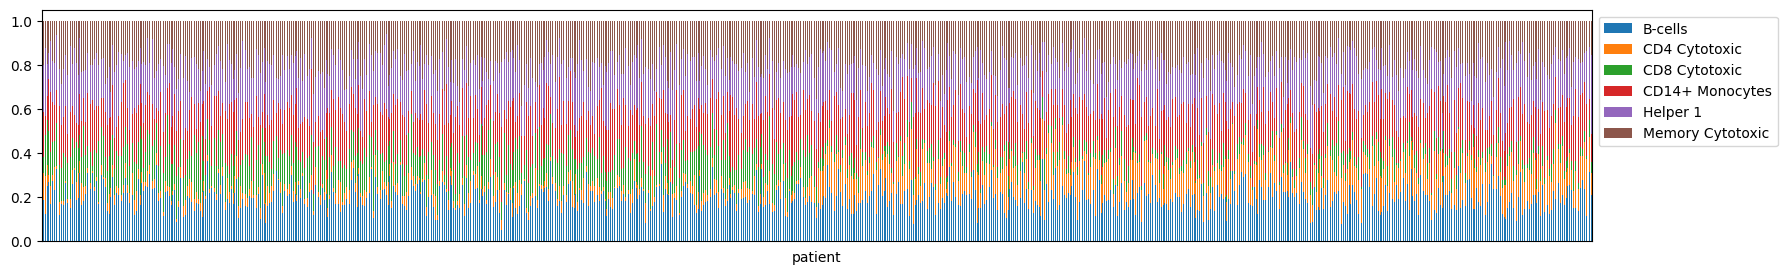

In [106]:
viz_props(full_adata.obs, figsize=[20,3])

In [16]:
import utils

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


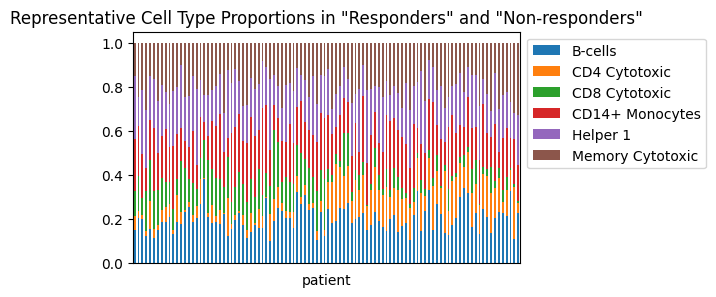

In [21]:
# make version of figure with just 100 patients
utils.viz_props(hvg_adata[hvg_adata.obs.patient.isin(["sim_pt"+str(i) for i in np.arange(50)+1] + ["sim_pt"+str(i) for i in np.arange(500,550)+1])].obs)
plt.title('Representative Cell Type Proportions in "Responders" and "Non-responders"')
plt.savefig('figures/simulated_props/syn_props_cd8_vs_cd4_0.05vs0.15_dirconc50_show100patients.pdf', dpi=300, bbox_inches="tight")#, backend='pgf')
plt.savefig('figures/simulated_props/syn_props_cd8_vs_cd4_0.05vs0.15_dirconc50_show100patients.png', dpi=300, bbox_inches="tight")#, backend='pgf')


In [28]:
# lognorm, HVG
full_adata.layers['counts'] = full_adata.X.copy()

print("lognorm data...")
sc.pp.normalize_total(full_adata, target_sum=1e4)
sc.pp.log1p(full_adata)
full_adata.layers['lognorm'] = full_adata.X.copy()

lognorm data...


In [29]:
print("compute HVG...")
sc.pp.highly_variable_genes(full_adata, layer="counts", flavor='seurat_v3', n_top_genes=5000)

compute HVG...


In [30]:
# save to disk just in case of crash
print("writing full anndata object...")
full_adata.write_h5ad("/data/rna_rep_learning/scset/synthetic_props_data/props_cd8_vs_cd4_{}vs{}_dirconc{}_{}patients.h5ad".format(
    dir_strength, 
    cell_type_dirichlet_concentrations_1['CD4 Cytotoxic']/dir_strength,
    cell_type_dirichlet_concentrations_1['CD8 Cytotoxic']/dir_strength,
    (d+1)*npatients), compression="gzip")

writing full anndata object...


In [31]:
# create a version of the anndata just with HVG, for slower preprocessing stepes
hvg_adata = full_adata[:,full_adata.var.highly_variable]#.write_h5ad("/data/rna_rep_learning/scset/synthetic_pheno_data/pheno_cd8t_fc4_10000patients_HVGonly.h5ad")#.format((d+1)*npatients), compression="gzip")
del full_adata

scale data...


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


compute PCA...


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


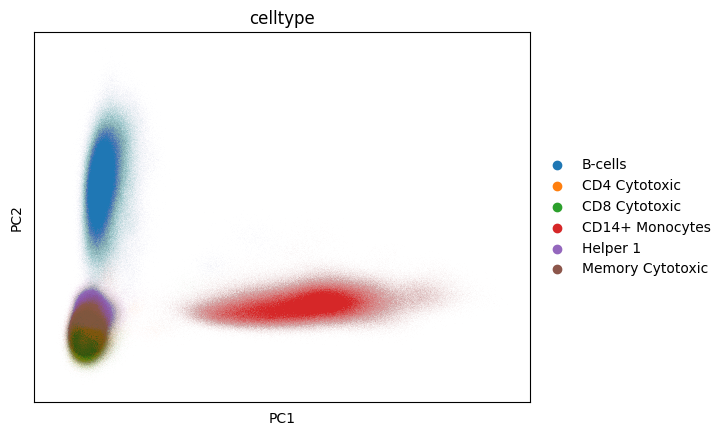

In [32]:
print("scale data...")
sc.pp.scale(hvg_adata, max_value=10)

print("compute PCA...")
sc.tl.pca(hvg_adata, svd_solver='arpack')
sc.pl.pca(hvg_adata, color='celltype')

In [33]:
#save to disk 
print("writing HVG subsetted, pre-processed (lognorm, pca) anndata object to disk...")
hvg_adata.write_h5ad("/data/rna_rep_learning/scset/synthetic_props_data/props_cd8_vs_cd4_{}vs{}_dirconc{}_{}patients_HVGonly.h5ad".format(
    cell_type_dirichlet_concentrations_1['CD4 Cytotoxic']/dir_strength,
    cell_type_dirichlet_concentrations_1['CD8 Cytotoxic']/dir_strength,
    dir_strength,
    (d+1)*npatients), compression="gzip")

writing HVG subsetted, pre-processed (lognorm, pca) anndata object to disk...


In [34]:
# havent run this yet, kernel died

sc.pp.neighbors(hvg_adata, n_neighbors=10, n_pcs=20)

sc.tl.umap(hvg_adata)

sc.pl.umap(hvg_adata, color=['celltype', 'group'], ncols=1)

#save to disk 
print("writing HVG subsetted, pre-processed (umap) anndata object to disk...")
hvg_adata.write_h5ad("/data/rna_rep_learning/scset/synthetic_props_data/props_cd8_vs_cd4_{}vs{}_dirconc{}_{}patients_HVGonly.h5ad".format(
    cell_type_dirichlet_concentrations_1['CD4 Cytotoxic']/dir_strength,
    cell_type_dirichlet_concentrations_1['CD8 Cytotoxic']/dir_strength,
    dir_strength,
    (d+1)*npatients), compression="gzip")   

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

# JULY UPDATE STOPPED HERE (for now)

In [ ]:
# pseudobulk of these sample

In [7]:
pseudobulk_counts = pd.DataFrame(sim_counts_Tsubtypes, index=sim_metadata_Tsubtypes.patient, columns=cd45_adata.var.index).reset_index().groupby("patient").sum()

In [8]:
pseudobulk_lognorm = np.log1p(np.divide(pseudobulk_counts.T, pseudobulk_counts.sum(axis=1)))

In [9]:
# top 100 variable genes
gene_stds = pseudobulk_lognorm.std(axis=1)
topvargenes = gene_stds.sort_values()[-100:].index

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


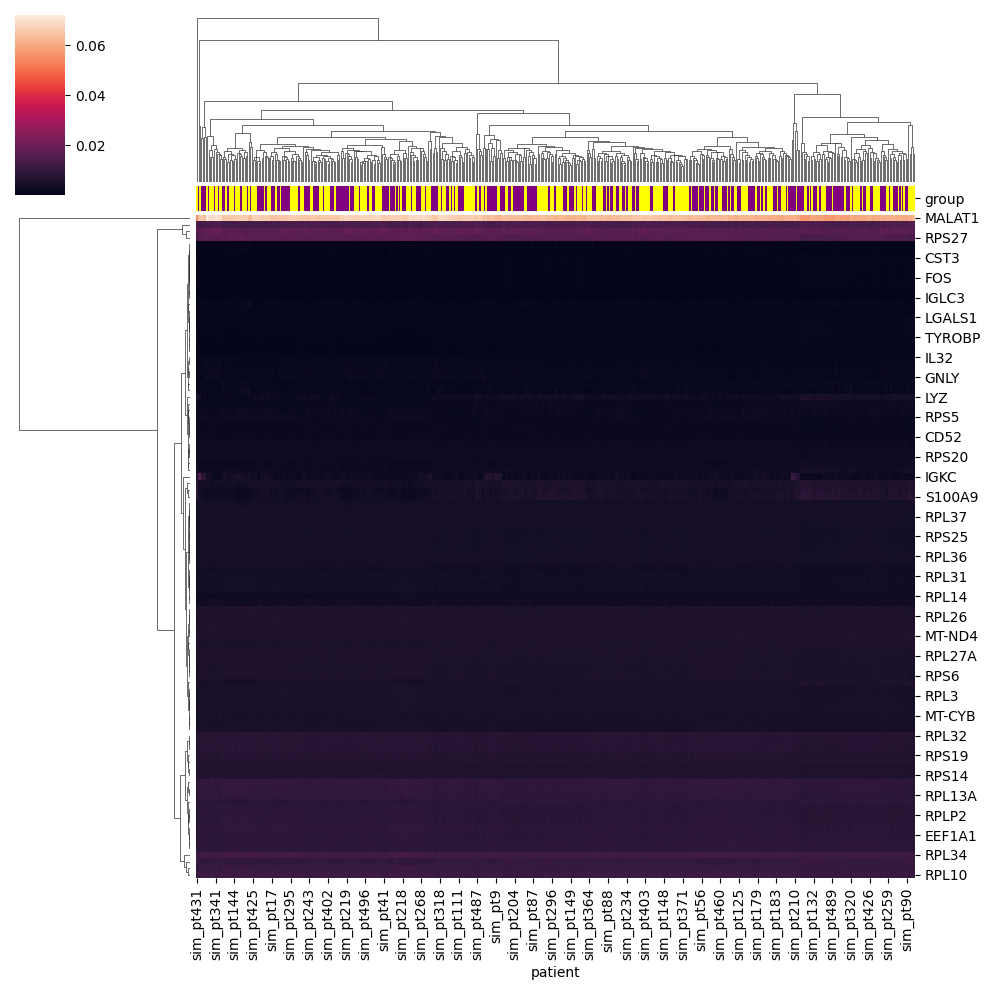

In [10]:
import seaborn as sns
sns.clustermap(pseudobulk_lognorm.loc[topvargenes,:], col_colors=sim_metadata_Tsubtypes[['patient','group']].drop_duplicates().set_index('patient').group.map({'group1':'purple', 'group2':'yellow'}))



In [11]:
sim_adata = sc.AnnData(sim_counts_Tsubtypes, obs=sim_metadata_Tsubtypes, var = cd45_adata.var)

sim_adata.layers['counts'] = sim_adata.X.copy()

sc.pp.normalize_total(sim_adata, target_sum=1e4)


/tmp/ipykernel_1047747/2623845696.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sim_adata = sc.AnnData(sim_counts_Tsubtypes, obs=sim_metadata_Tsubtypes, var = cd45_adata.var)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
sc.pp.log1p(sim_adata)


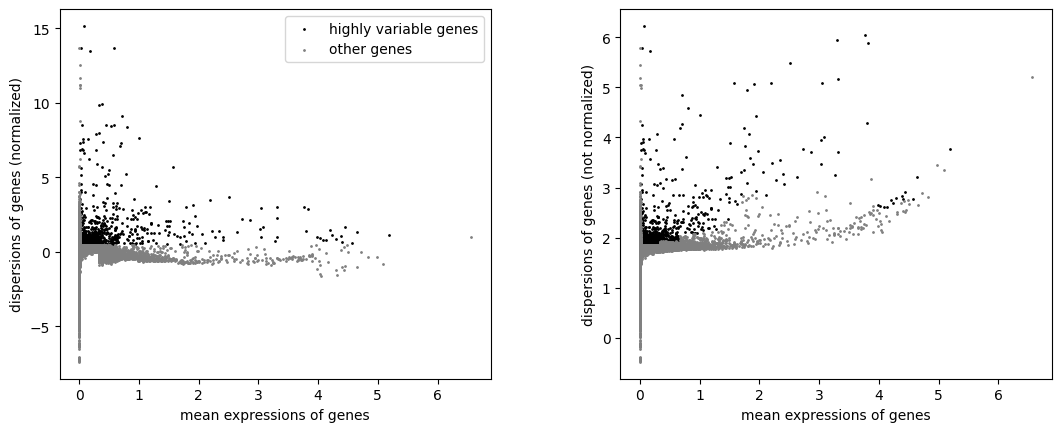

In [13]:
sc.pp.highly_variable_genes(sim_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(sim_adata)


In [14]:
sim_adata.layers['lognorm'] = sim_adata.X.copy()


In [15]:
sc.pp.scale(sim_adata, max_value=10)


In [16]:
sc.tl.pca(sim_adata, svd_solver='arpack')


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


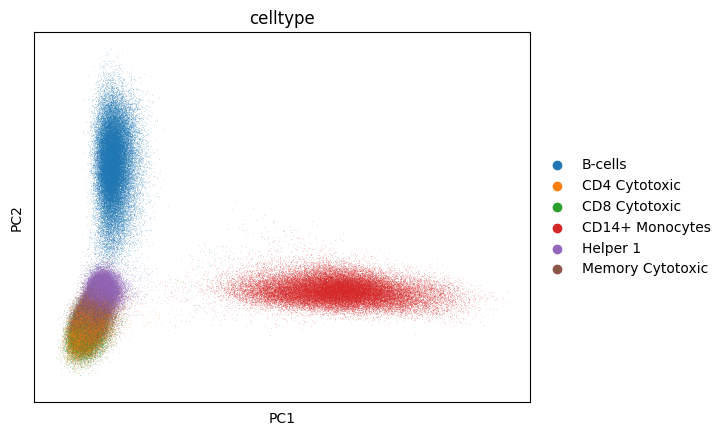

In [17]:
sc.pl.pca(sim_adata, color='celltype')


In [18]:
sim_adata.obs.celltype.value_counts()

CD14+ Monocytes     44912
Memory Cytotoxic    44821
Helper 1            44309
B-cells             43899
CD8 Cytotoxic       22843
CD4 Cytotoxic       21833
Name: celltype, dtype: int64

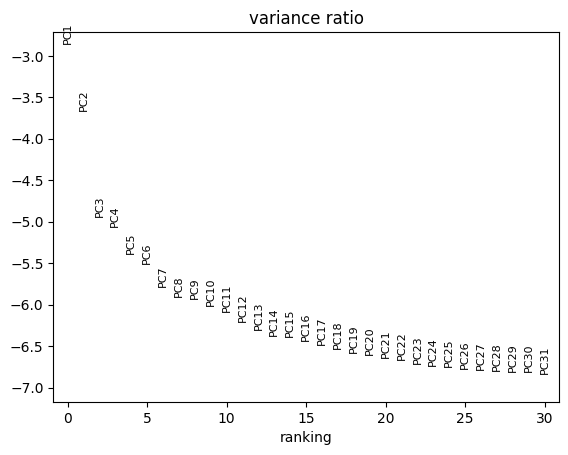

In [19]:
sc.pl.pca_variance_ratio(sim_adata, log=True)


In [20]:
sc.pp.neighbors(sim_adata, n_neighbors=10, n_pcs=20)


In [21]:
sc.tl.umap(sim_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


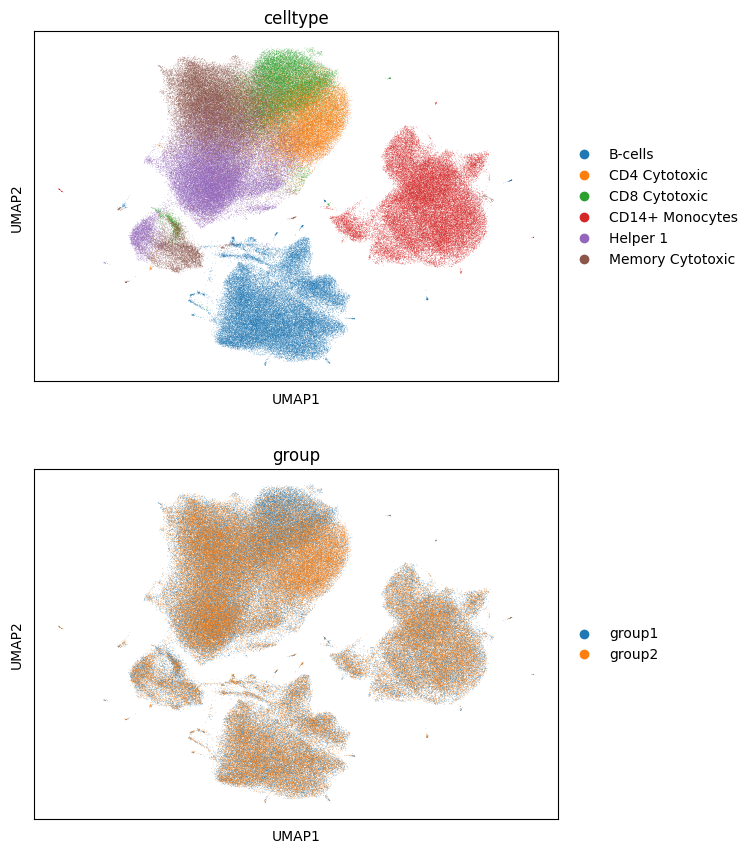

In [24]:
sc.pl.umap(sim_adata, color=['celltype', 'group'], ncols=1)


In [23]:
# save adata
sim_adata.write_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_tsubtypes_adata.h5ad")

In [3]:
sim_adata = sc.read_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_tsubtypes_adata.h5ad")

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/tmp/ipykernel_2414616/311809603.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  obs_df.celltype.cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_2414616/311809603.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pt_totalcells = celltypecounts.groupby("patient").sum().iloc[:,[0]].reset_index().rename(columns={'ncells':'pt_totalcells'})


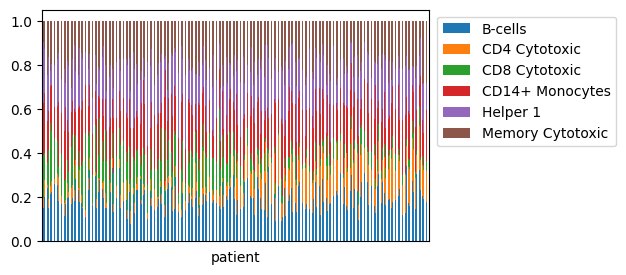

In [9]:
viz_props(sim_adata.obs)

# make it slightly less challenging (memory cytotoxic, helper 1, cd4 and cd8, and alter the proportions of cd4 and cd8 between responders/non-responders)

In [4]:
#temporarily convert to more specific cell types
cd45_adata.obs.celltype = cd45_adata.obs.Tcellsubtype.astype('str').replace('nan',np.NaN).fillna(cd45_adata.obs.celltype.astype('str'))

In [5]:
scvi.model.SCVI.setup_anndata(cd45_adata)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
#load trained scvi model
with open("/localdata/rna_rep_learning/scset/scvi_data/cd45model.pkl", "rb") as f: # "wb" because we want to write in binary mode
    fullmodel = pickle.load(f)   

In [7]:
cell_types = ["CD4 Cytotoxic", "CD8 Cytotoxic", "Helper 1", "Memory Cytotoxic", "B-cells", "CD14+ Monocytes"]
dir_strength = 50
cell_type_dirichlet_concentrations_1={"CD4 Cytotoxic":0.1*dir_strength, "CD8 Cytotoxic":0.2*dir_strength, "Helper 1":0.175*dir_strength, "Memory Cytotoxic":0.175*dir_strength, "B-cells":0.175*dir_strength, "CD14+ Monocytes":0.175*dir_strength}
cell_type_dirichlet_concentrations_2={"CD4 Cytotoxic":0.2*dir_strength, "CD8 Cytotoxic":0.1*dir_strength, "Helper 1":0.175*dir_strength, "Memory Cytotoxic":0.175*dir_strength, "B-cells":0.175*dir_strength, "CD14+ Monocytes":0.175*dir_strength}
npatients = 500
mean_ncells = 445
total_cells_pp = scipy.stats.poisson.rvs(mean_ncells, size=npatients)
sim_counts_Tsubtypes = np.empty((np.sum(total_cells_pp), cd45_adata.shape[1]))
verbose=False

cell_index = 0
for i in np.arange(npatients):
    if i % 100 == 0:
        print(i)
    if i <=(npatients/2-1):    
        sim_counts_Tsubtypes[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = sample_pt_cells_scvi(cd45_adata, fullmodel, cell_types, cell_type_dirichlet_concentrations_1, total_cells_pp[i], ptname="sim_pt{}".format(i+1), groupname="group1")

    else:
        sim_counts_Tsubtypes[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = sample_pt_cells_scvi(cd45_adata, fullmodel, cell_types, cell_type_dirichlet_concentrations_2, total_cells_pp[i], ptname="sim_pt{}".format(i+1), groupname="group2")
        
    cell_index += total_cells_pp[i]
    if i==0:
        sim_metadata_Tsubtypes = joint_obs_Tsubtypes.copy()
    else: 
        sim_metadata_Tsubtypes = pd.concat([sim_metadata_Tsubtypes, joint_obs_Tsubtypes], axis=0)


0
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
100
200
300
400


In [8]:
celltype_counts = sim_metadata_Tsubtypes[['celltype','group','patient']].groupby(["group","patient","celltype"]).size().unstack()
celltype_counts

celltype          B-cells  CD14+ Monocytes  CD4 Cytotoxic  CD8 Cytotoxic  \
group  patient                                                             
group1 sim_pt1         42              116             17            126   
       sim_pt10        52              115            103             59   
       sim_pt100      120               82             15             71   
       sim_pt101      135               75             43             81   
       sim_pt102       87               78             30            114   
...                   ...              ...            ...            ...   
group2 sim_pt496       53               76             74             38   
       sim_pt497       83              138             77             49   
       sim_pt498       59              112             99             54   
       sim_pt499       82               69             54             40   
       sim_pt500       87               46            103             39   

celltype          Helper 1  Memory Cytotoxic  
group  patient                                
group1 sim_pt1          78                85  
       sim_pt10         47                76  
       sim_pt100       117                54  
       sim_pt101        38                77  
       sim_pt102        66                44  
...                    ...               ...  
group2 sim_pt496        86                98  
       sim_pt497        60                51  
       sim_pt498        76                83  
       sim_pt499       127                59  
       sim_pt500        94                69  

[500 rows x 6 columns]

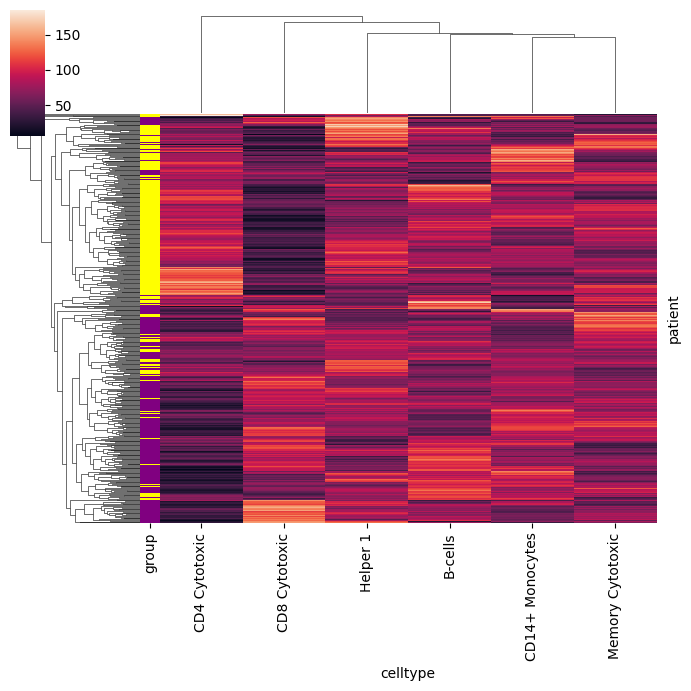

In [9]:
sns.clustermap(celltype_counts.reset_index().drop("group", axis=1).set_index("patient").fillna(0), row_colors=celltype_counts.reset_index().set_index("patient").group.map({"group1":"purple", "group2":"yellow"}), yticklabels=False, figsize=(7,7))

In [15]:
# pseudobulk of these sample

pseudobulk_counts = pd.DataFrame(sim_counts_Tsubtypes, index=sim_metadata_Tsubtypes.patient, columns=cd45_adata.var.index).reset_index().groupby("patient").sum()

pseudobulk_lognorm = np.log1p(np.divide(pseudobulk_counts.T, pseudobulk_counts.sum(axis=1)))

# top 100 variable genes
gene_stds = pseudobulk_lognorm.std(axis=1)
topvargenes = gene_stds.sort_values()[-100:].index

import seaborn as sns
sns.clustermap(pseudobulk_lognorm.loc[topvargenes,:], figsize=(7,7), col_colors=sim_metadata_Tsubtypes[['patient','group']].drop_duplicates().set_index('patient').group.map({'group1':'purple', 'group2':'yellow'}))



In [10]:
sim_adata = sc.AnnData(sim_counts_Tsubtypes, obs=sim_metadata_Tsubtypes, var = cd45_adata.var)

sim_adata.layers['counts'] = sim_adata.X.copy()

sc.pp.normalize_total(sim_adata, target_sum=1e4)


/tmp/ipykernel_2877351/2623845696.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sim_adata = sc.AnnData(sim_counts_Tsubtypes, obs=sim_metadata_Tsubtypes, var = cd45_adata.var)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
sc.pp.log1p(sim_adata)


In [ ]:
sc.pp.highly_variable_genes(sim_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(sim_adata)


In [ ]:
sim_adata.layers['lognorm'] = sim_adata.X.copy()


In [ ]:
sc.pp.scale(sim_adata, max_value=10)


In [ ]:
sc.tl.pca(sim_adata, svd_solver='arpack')


In [ ]:
sc.pl.pca(sim_adata, color='celltype')


In [ ]:
sim_adata.obs.celltype.value_counts()

In [ ]:
sc.pl.pca_variance_ratio(sim_adata, log=True)


In [37]:
sc.pp.neighbors(sim_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(sim_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


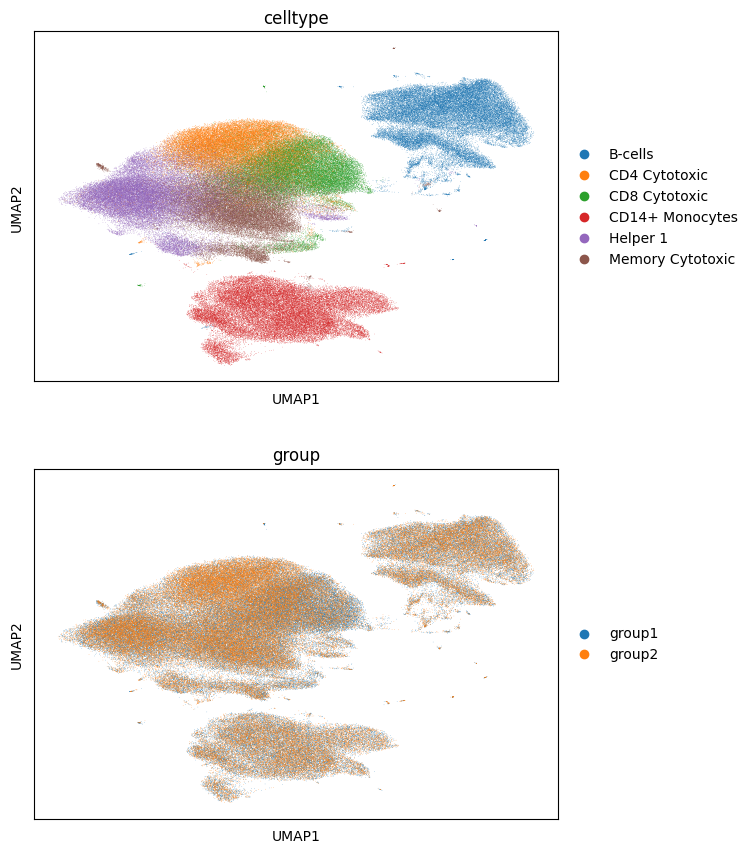

In [38]:
sc.pl.umap(sim_adata, color=['celltype', 'group'], ncols=1)


In [ ]:
# save adata
sim_adata.write_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_tsubtypes_0.2vs0.1_adata_v2.h5ad")

In [40]:
del sim_adata, sim_counts_Tsubtypes

In [ ]:
sim_adata = sc.read_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_tsubtypes_adata.h5ad")

In [ ]:
viz_props(sim_adata.obs)

## if I sample 50 version of 100 B and T cells resp., how similar are those cells to each others?

In [134]:
n_samples=50

In [135]:
Bcellsamples = Bcellmodel.posterior_predictive_sample(indices=np.arange(100), n_samples=n_samples)

In [136]:
Tcellsamples = Tcellmodel.posterior_predictive_sample(indices=np.arange(100), n_samples=n_samples)

In [137]:
full_data = np.concatenate((np.concatenate([Bcellsamples[:,:,i] for i in np.arange(n_samples)]), np.concatenate([Tcellsamples[:,:,i] for i in np.arange(n_samples)])), axis=0)

In [138]:
joint_adata = sc.AnnData(
    full_data, 
    obs = pd.DataFrame({"celltype": np.concatenate((np.repeat("B", Bcellsamples.reshape(-1, cd45_adata.shape[1]).shape[0]),
                                                    np.repeat("T", Tcellsamples.reshape(-1, cd45_adata.shape[1]).shape[0])))}),
    var = cd45_adata.var
)


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


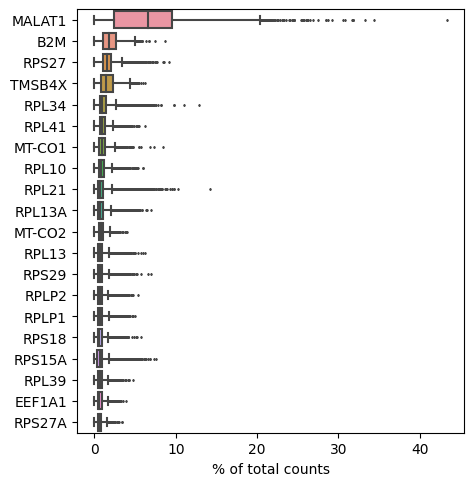

In [139]:
sc.pl.highest_expr_genes(joint_adata, n_top=20, )


In [140]:
sc.pp.filter_cells(joint_adata, min_genes=200)
sc.pp.filter_genes(joint_adata, min_cells=3)

In [141]:
joint_adata.var['mt'] = joint_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(joint_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

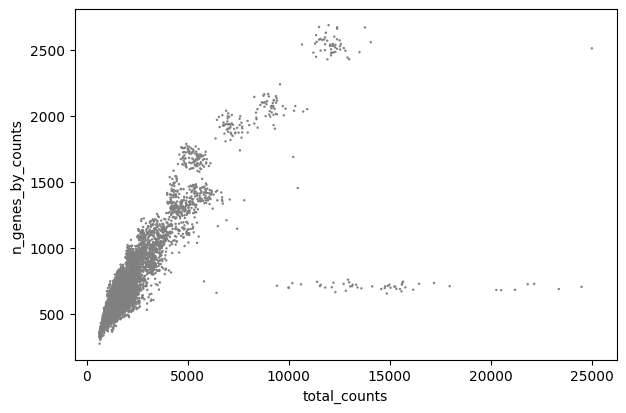

In [142]:
sc.pl.scatter(joint_adata, x='total_counts', y='n_genes_by_counts')

In [143]:
joint_adata.layers['counts'] = joint_adata.X.copy()

sc.pp.normalize_total(joint_adata, target_sum=1e4)

In [144]:
sc.pp.log1p(joint_adata)


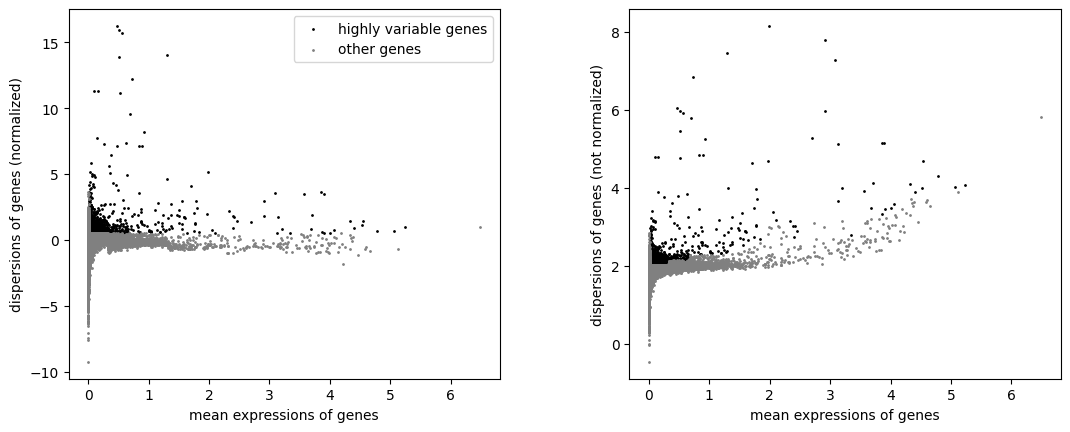

In [145]:
sc.pp.highly_variable_genes(joint_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(joint_adata)


In [146]:
joint_adata.layers['lognorm'] = joint_adata.X.copy()


In [147]:
sc.pp.scale(joint_adata, max_value=10)


In [148]:
sc.tl.pca(joint_adata, svd_solver='arpack')


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


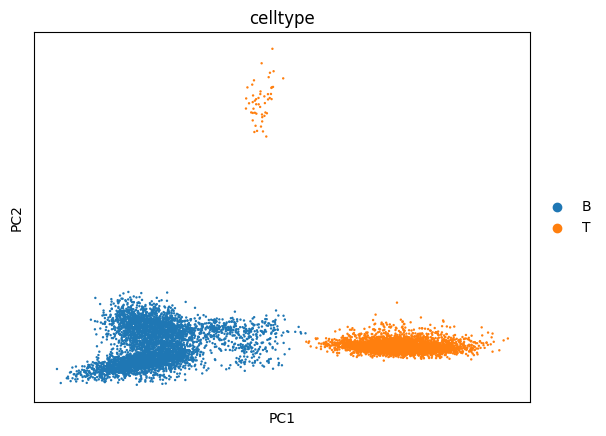

In [149]:
sc.pl.pca(joint_adata, color='celltype')


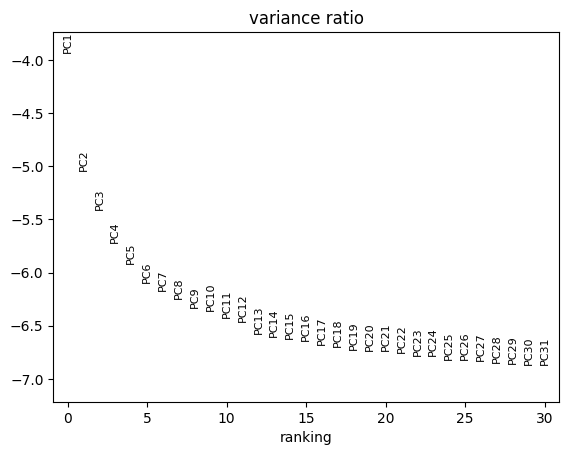

In [150]:
sc.pl.pca_variance_ratio(joint_adata, log=True)


In [151]:
sc.pp.neighbors(joint_adata, n_neighbors=10, n_pcs=20)


In [152]:
sc.tl.umap(joint_adata)

In [154]:
sc.tl.leiden(joint_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


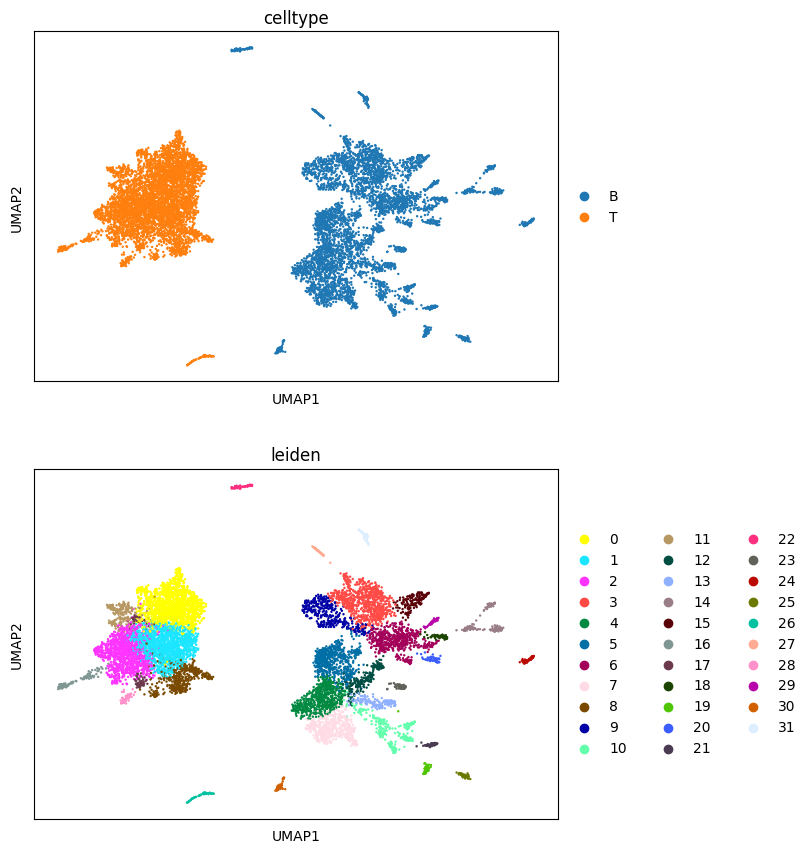

In [155]:
sc.pl.umap(joint_adata, color=['celltype', 'leiden'], ncols=1)


In [157]:
joint_adata.obs.groupby(["leiden"]).size()

leiden
0     1506
1     1397
2     1143
3      804
4      614
5      611
6      559
7      478
8      441
9      373
10     291
11     220
12     211
13     156
14     149
15     148
16      97
17      96
18      56
19      51
20      51
21      50
22      50
23      50
24      50
25      50
26      50
27      50
28      50
29      50
30      49
31      49
dtype: int64

## if I sample 20 samples per cell for all cells, how does it look?

In [162]:
n_samples = 20

In [163]:
Bcellsamples = Bcellmodel.posterior_predictive_sample(n_samples=n_samples)

In [164]:
Tcellsamples = Tcellmodel.posterior_predictive_sample(n_samples=n_samples)

In [165]:
full_data = np.concatenate((np.concatenate([Bcellsamples[:,:,i] for i in np.arange(n_samples)]), np.concatenate([Tcellsamples[:,:,i] for i in np.arange(n_samples)])), axis=0)

In [166]:
joint_adata = sc.AnnData(
    full_data, 
    obs = pd.DataFrame({"celltype": np.concatenate((np.repeat("B", Bcellsamples.reshape(-1, cd45_adata.shape[1]).shape[0]),
                                                    np.repeat("T", Tcellsamples.reshape(-1, cd45_adata.shape[1]).shape[0])))}),
    var = cd45_adata.var
)


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


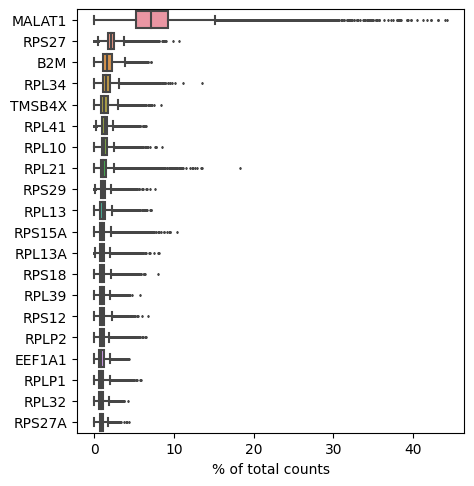

In [167]:
sc.pl.highest_expr_genes(joint_adata, n_top=20, )


In [169]:
sc.pp.filter_cells(joint_adata, min_genes=200)
sc.pp.filter_genes(joint_adata, min_cells=3)

In [170]:
joint_adata.var['mt'] = joint_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(joint_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

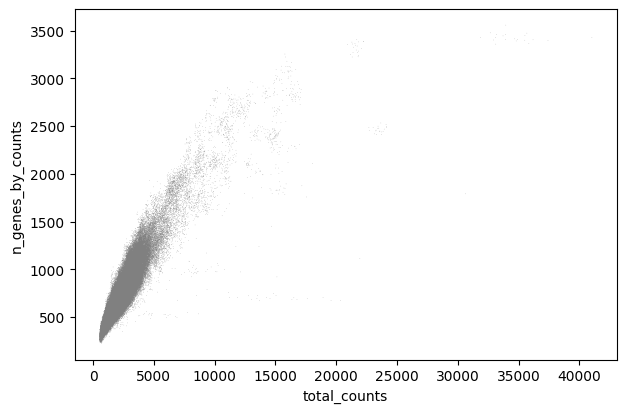

In [171]:
sc.pl.scatter(joint_adata, x='total_counts', y='n_genes_by_counts')

In [172]:
joint_adata.layers['counts'] = joint_adata.X.copy()

sc.pp.normalize_total(joint_adata, target_sum=1e4)

In [173]:
sc.pp.log1p(joint_adata)


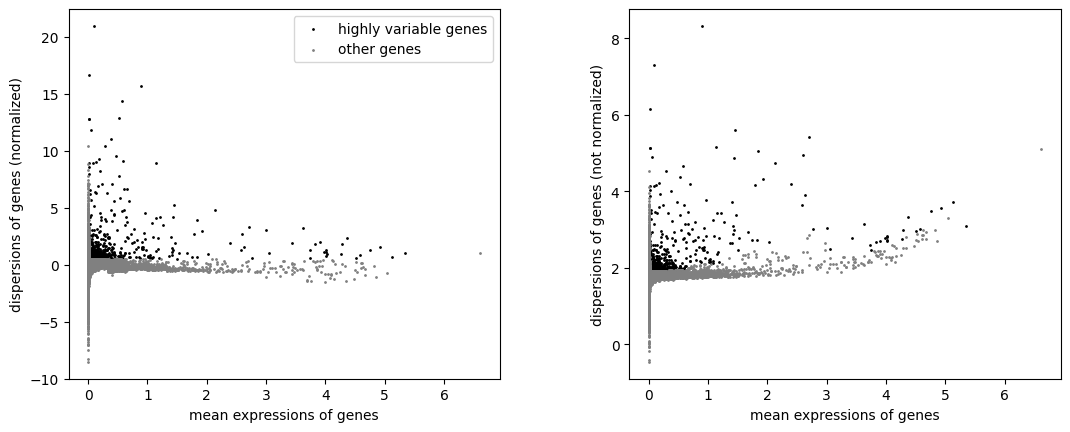

In [174]:
sc.pp.highly_variable_genes(joint_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(joint_adata)


In [175]:
joint_adata.layers['lognorm'] = joint_adata.X.copy()


In [176]:
sc.pp.scale(joint_adata, max_value=10)


In [177]:
sc.tl.pca(joint_adata, svd_solver='arpack')


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


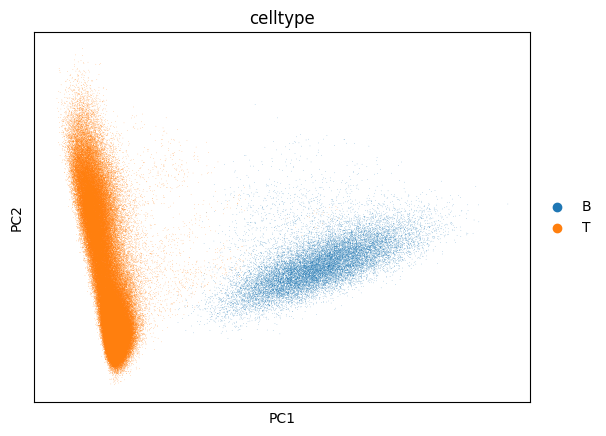

In [178]:
sc.pl.pca(joint_adata, color='celltype')


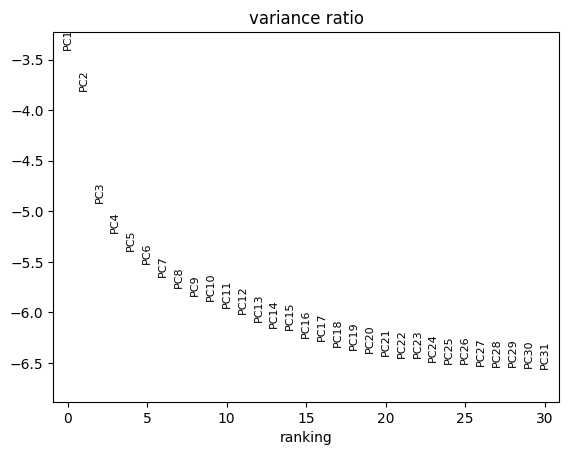

In [179]:
sc.pl.pca_variance_ratio(joint_adata, log=True)


In [180]:
sc.pp.neighbors(joint_adata, n_neighbors=10, n_pcs=20)


In [181]:
sc.tl.umap(joint_adata)

In [182]:
sc.tl.leiden(joint_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


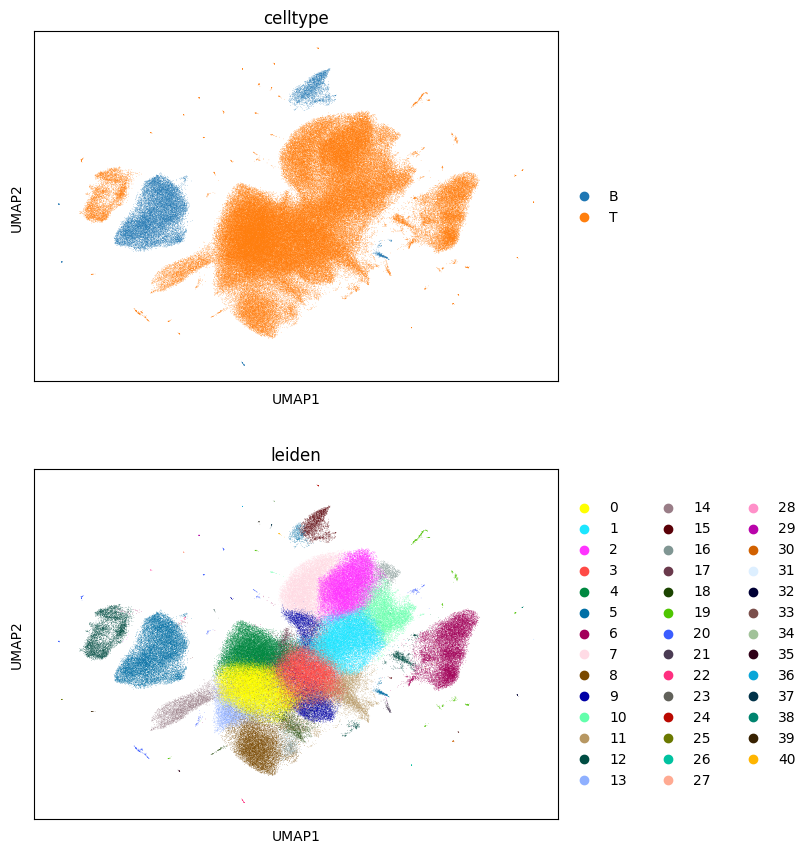

In [183]:
sc.pl.umap(joint_adata, color=['celltype', 'leiden'], ncols=1)


In [184]:
joint_adata.obs.groupby(["leiden"]).size()

leiden
0     30814
1     21931
2     21345
3     20993
4     19818
5     17680
6     15074
7     12883
8     10794
9      8636
10     8636
11     7506
12     6554
13     5521
14     5120
15     2320
16     1992
17     1932
18     1894
19      497
20      438
21      124
22       60
23       21
24       20
25       20
26       20
27       20
28       20
29       20
30       20
31       20
32       20
33       20
34       20
35       20
36       20
37       20
38       20
39       19
40       18
dtype: int64